In [105]:
## Import and data sources
import numpy as np                              # version: 1.17.2
import pandas as pd                             # version: 1.0.5
import urllib.request as req                    # version: 3.6
import ast
import sklearn.model_selection as ms            # version: 0.21.3
from sklearn.preprocessing import MinMaxScaler  # version: 0.21.3
import xgboost as xgb                           # version: 1.0.2
import shap                                     # version: 0.34.0
import matplotlib.pyplot as plt                 # version: 2.2.3
import seaborn as sns                           # version: 0.9.0
import sys
import os
import networkx as nx
import math
from matplotlib.lines import Line2D

# To supress warnings from shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
N_THREADS = 88  ## NOTE: The number of threads for parallel runs. Modify as needed.
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
    
sns.set(font_scale=1.25, style='white')

census_key = 'a4feafd1e894848eda9a783376cf7977222aecd2' ## The key from https://www.census.gov/data/developers.html "Request a key".

# APIs from the US Census Bureau
population_density_url = 'https://api.census.gov/data/2019/pep/population?get=DENSITY&in=state:*&for=county:*&key={}'.format(census_key)
above_65_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S0101_C02_030E&in=state:*&for=county:*&key={}'.format(census_key)
transport_url = 'https://api.census.gov/data/2018/acs/acs5?get=GEO_ID,NAME,B08006_001E,B08006_003E,B08006_017E&in=state:*&for=county:*&key={}'.format(census_key)
race_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP05_0070E,DP05_0077E&in=state:*&for=county:*&key={}'.format(census_key)
poverty_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S1701_C03_001E&in=state:*&for=county:*&key={}'.format(census_key)
income_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S1902_C03_019E&in=state:*&for=county:*&key={}'.format(census_key)
employed_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S2301_C03_001E&in=state:*&for=county:*&key={}'.format(census_key)
unemployment_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S2301_C04_001E&in=state:*&for=county:*&key={}'.format(census_key)
mean_commute_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S0801_C01_046E&in=state:*&for=county:*&key={}'.format(census_key)
labour_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP03_0028PE,DP03_0030PE,DP03_0031PE&in=state:*&for=county:*&key={}'.format(census_key)
insurance_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP03_0099PE&in=state:*&for=county:*&key={}'.format(census_key)

# links to the JHU GitHub
jhu_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
jhu_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

In [10]:
def sectorAnalyze(df, df_c, useDensity=False, type=0, scale=False, N=100):
    ''' A function to prepare the data for the BDT analysis
        arguments:
            df: the dataframe for the socio-economic conditions
            df_c: the dataframe for covid-19 prevalence
            useDensity: boolean to determine whether density is used in the analysis
            type:
                0: death rate
                1: confirmed case rate
                2: fatality rate
            scale: boolean to toggle scaling of the features
            N: The number of BDTs in an ensemble
            run_BDT: boolean to determin whether to call run_BDT() after cleaning the data
        return:
            df: the combined dataframe
    '''
    df = pd.merge(df, df_c, on='FIPS')
    if type == 0: df['death rate'] = np.log10((df['deaths']) / df['Population'] * 100000. + 1.)
    if type == 1: df['confirmed rate'] = np.log10((df['confirmed']) / df['Population'] * 100000. + 1.)
    if type == 2: df['fatality rate'] = np.log10((df['deaths']) / df['confirmed'] * 100. + 1.)
    if useDensity: df.drop(columns=['FIPS', 'Population', 'deaths', 'confirmed'], inplace=True)
    else: df.drop(columns=['FIPS', 'Population', 'deaths', 'confirmed', 'Density'], inplace=True)

    return df

def makeCorrelationPlot(df, cbar=False):
    ''' A function to make the correlation plot using sns
        arguments:
            df: the dataframe to make the plot from
            cbar: boolean to decide whether to plot the colourbar
        return:
            fig: the figure
            ax: the axes
    '''
    fig, ax = plt.subplots(figsize=(15.5, 13))
    mask = np.zeros((df.shape[1],df.shape[1]))
    mask[np.triu_indices_from(mask)] = True
    np.fill_diagonal(mask,0)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cbar_kws = {"aspect": 50, "ticks": [-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]}
    sns.heatmap(round(df.corr(method='pearson'), 2)+0., mask=mask, annot=True, cmap=cmap, vmin=-1.0, vmax=1.0, cbar_kws=cbar_kws, cbar=cbar)
    return fig, ax
    
def get_census_data(url):
    ''' A function to get the data from USA Census Bureau
        arguments:
            url: the url for the API call
        return:
            df: the dataframe with the pulled data
    '''
    df = pd.DataFrame(ast.literal_eval(req.urlopen(req.Request(url)).read().decode('utf8').replace('null', '"1"')))
    df.columns = df.iloc[0]
    df = df[1:]
    df['FIPS'] = df.pop('GEO_ID').apply(lambda x: int(x[-5:]))
    return df

In [3]:
## The density data from census.gov. We are removing the counties with density = 0 (Puerto Rico)
density = pd.DataFrame(ast.literal_eval(req.urlopen(req.Request(population_density_url)).read().decode('utf8').replace('null', '"0"')))
density.columns = density.iloc[0]
density = density[1:]
density.DENSITY = density.DENSITY.astype('float32')
density.state = density.state.astype('string')
density.county = density.county.astype('string')
density['FIPS'] = density['state'] + density['county']
density.FIPS = density.FIPS.astype('int32')
density = density.drop(labels=['state', 'county'], axis=1)
columns = density.columns.tolist()
columns = columns[::-1]
density = density[columns]
density.drop(density[density['DENSITY'] == 0].index , inplace=True)
density.DENSITY = np.log10(density.DENSITY)
density.rename(columns={'DENSITY': 'Density'}, inplace=True)

In [4]:
## The JHU data
deaths = pd.read_csv(jhu_deaths)
deaths.drop(deaths[(deaths['FIPS'] < 1000) | (deaths['FIPS'] > 57000)].index , inplace=True)
deaths.dropna(inplace=True)

confirmed = pd.read_csv(jhu_confirmed)
confirmed.drop(confirmed[(confirmed['FIPS'] < 1000) | (confirmed['FIPS'] > 57000)].index , inplace=True)
confirmed.dropna(inplace=True)

deaths_df = deaths[['FIPS', 'Population', '8/16/20']]
confirmed_df = confirmed[['FIPS', '8/6/20', '8/16/20']]

## Death rate computation with the JHU data
df_covid19 = deaths_df.copy()
df_covid19.rename(columns={df_covid19.columns[-1]: 'deaths'}, inplace=True)
df_covid19['confirmed'] = confirmed_df['8/6/20']
df_covid19.dropna(inplace=True)
df_covid19.reset_index(drop=True, inplace=True)

## Cleaning out low statistics data and merging JHU with density data
df_cut = df_covid19.drop(df_covid19[(df_covid19['confirmed'] < 1) & (df_covid19['deaths'] < 1)].index)
df_cut.reset_index(drop=True, inplace=True)

In [5]:
# The FIPS and state names
df_census = get_census_data(above_65_url)
df_census = df_census[['FIPS', 'NAME']]
df_census['State'] = df_census.pop('NAME').str.split(', ').str[1]
df_census = df_census.sort_values(df_census.columns[0], ignore_index=True)
df_census = pd.merge(df_census, density, on='FIPS')

# 2018 5 year ACS data on Age
dft = get_census_data(above_65_url)
dft = dft[['FIPS', 'S0101_C02_030E']]
dft.rename(columns={'S0101_C02_030E': 'Senior Citizen'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Senior Citizen'] = df_census['Senior Citizen'].apply(lambda x: float(x))/100.

# 2018 5 year ACS data on transport used
dft = get_census_data(transport_url)
dft['Transit-1'] = 1. - (dft['B08006_003E'].astype('float')+dft['B08006_017E'].astype('float'))/dft['B08006_001E'].astype('float')
dft = dft[['FIPS', 'Transit-1']]
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Transit'] = df_census.pop('Transit-1')
df_census.at[df_census[df_census['FIPS']==35039].index, 'Transit'] = 0.159 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on non-white
dft = get_census_data(race_url)
# dft['Non-White'] = 1. - dft['B02001_002E'].astype('float')/dft['B02001_001E'].astype('float')
dft['Non-White'] = 1. - dft['DP05_0077E'].astype('float')/dft['DP05_0070E'].astype('float')
dft = dft[['FIPS', 'Non-White']]
df_census = pd.merge(df_census, dft, on='FIPS')

# 2018 5 year ACS data on Poverty
dft = get_census_data(poverty_url)
dft = dft[['FIPS', 'S1701_C03_001E']]
dft.rename(columns={'S1701_C03_001E': 'Poverty-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Poverty'] = df_census.pop('Poverty-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Poverty'] = 0.237 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Income per capita
dft = get_census_data(income_url)
dft = dft[['FIPS', 'S1902_C03_019E']]
dft.rename(columns={'S1902_C03_019E': 'Income/Capita'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Income/Capita'] = df_census['Income/Capita'].apply(lambda x: float(x))
df_census.at[df_census[df_census['FIPS']==35039].index, 'Income/Capita'] = 19678 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Employment
dft = get_census_data(employed_url)
dft = dft[['FIPS', 'S2301_C03_001E']]
dft.rename(columns={'S2301_C03_001E': 'Employed-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Employed'] = df_census.pop('Employed-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Employed'] = 0.382287 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Unemployment
dft = get_census_data(unemployment_url)
dft = dft[['FIPS', 'S2301_C04_001E']]
dft.rename(columns={'S2301_C04_001E': 'Unemployment-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Unemployment'] = df_census.pop('Unemployment-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Unemployment'] = 0.114 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Mean Commute in minutes
dft = get_census_data(mean_commute_url)
dft = dft[['FIPS', 'S0801_C01_046E']]
dft.rename(columns={'S0801_C01_046E': 'MeanCommute'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['MeanCommute'] = df_census['MeanCommute'].apply(lambda x: float(x))
df_census.at[df_census[df_census['FIPS']==35039].index, 'MeanCommute'] = 26.2 ## Imputed value from 2011 since values are null in 2018
df_census.at[df_census[df_census['FIPS']==48301].index, 'MeanCommute'] = 25.4 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Labour
dft = get_census_data(labour_url)
dft['Labour'] = (dft['DP03_0028PE'].astype('float') + dft['DP03_0030PE'].astype('float') + dft['DP03_0031PE'].astype('float'))/100.
dft = dft[['FIPS', 'Labour']]
df_census = pd.merge(df_census, dft, on='FIPS')
df_census.at[df_census[df_census['FIPS']==35039].index, 'Labour'] = 0.271 + 0.108 + 0.07 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Health Insurance
dft = get_census_data(insurance_url)
dft = dft[['FIPS', 'DP03_0099PE']]
dft.rename(columns={'DP03_0099PE': 'Uninsured'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Uninsured'] = df_census.pop('Uninsured').apply(lambda x: float(x))/100.

In [6]:
# Collecting all the necessary features into one dataframe
df_census_curated = pd.DataFrame()
df_census_curated['FIPS'] = df_census['FIPS']
df_census_curated['State'] = df_census['State']
df_census_curated['Density'] = df_census['Density']
df_census_curated['Non-White'] = df_census['Non-White']
df_census_curated['Poverty'] = df_census['Poverty']
df_census_curated['Income'] = df_census['Income/Capita']
df_census_curated['Unemployment'] = df_census['Unemployment']
df_census_curated['Uninsured'] = df_census['Uninsured']
df_census_curated['Employed'] = df_census['Employed']
df_census_curated['Labor'] = df_census['Labour']
df_census_curated['Transit'] = df_census['Transit']
df_census_curated['Mean Commute'] = df_census['MeanCommute']
df_census_curated['Senior Citizen'] = df_census['Senior Citizen']

In [137]:
def makeGraph(G, df, threshold, pos, seed=0, iterations=0, kfactor=0):
    # clear the graph
    G.clear()
    
    # define the couplings
    var = {}
    nodelist = []
    names = list(df.columns)
    size = len(names)
    for i in range(size):
        var[i] = names[i]
        nodelist.append(i)

    corr = np.array(df.corr(method='pearson'))

    # add weight to the edges
    for i in range(0,size):
        for j in range(i+1,size):
            G.add_edge(i,j,weight=math.exp(np.abs(corr[i,j])), sign=np.sign(corr[i,j]))

    # node layouts
    if not pos or len(pos) < size:
        if pos:
            print("positions of nodes need to be recomputed since input position array is smaller")
        pos = nx.fruchterman_reingold_layout(G, iterations=iterations, k=kfactor, threshold=1e-16, weight='weight', seed=seed)

    steps = [0.1, 0.6, 0.8]
    # define correlation maps with edge positions
    epos0 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(steps[0]) <= d['weight'] < math.exp(threshold) and d['sign'] == 1.]
    epos1 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(threshold) <= d['weight'] < math.exp(steps[1]) and d['sign'] == 1.]
    epos2 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(steps[1]) <= d['weight'] < math.exp(steps[2]) and d['sign'] == 1.]
    epos3 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(steps[2]) <= d['weight'] < math.exp(1.) and d['sign'] == 1.]
    eneg0 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(steps[0]) <= d['weight'] < math.exp(threshold) and d['sign'] == -1.]
    eneg1 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(threshold) <= d['weight'] < math.exp(steps[1]) and d['sign'] == -1.]
    eneg2 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(steps[1]) <= d['weight'] < math.exp(steps[2]) and d['sign'] == -1.]
    eneg3 = [(u, v) for (u, v, d) in G.edges(data=True) if math.exp(steps[2]) <= d['weight'] < math.exp(1.) and d['sign'] == -1.]

    # draw nodes
    nodesize = 1600
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist[:-3], alpha=1, node_color='#cab9d3', node_size=nodesize,
                               edgecolors='#cab9d3', linewidths=2)
    nx.draw_networkx_nodes(G, pos, nodelist=nodelist[-3:], alpha=1, node_color='#b5eeff', node_size=nodesize,
                               edgecolors='#b5eeff', linewidths=2)

    # edges weighting and drawing
    nx.draw_networkx_edges(G, pos, edgelist=epos0, width=1, alpha=0.1, edge_color='#5b5f6d')  # gray
    nx.draw_networkx_edges(G, pos, edgelist=epos1, width=2, alpha=0.4, edge_color='#ff741a', connectionstyle='Arc3, rad=10')  # orange
    nx.draw_networkx_edges(G, pos, edgelist=epos2, width=4, alpha=0.9, edge_color='#a53860', connectionstyle='Arc3, rad=10')  # red
    nx.draw_networkx_edges(G, pos, edgelist=epos3, width=5, alpha=1, edge_color='#005d9a', connectionstyle='Arc3, rad=10')  # blue
    nx.draw_networkx_edges(G, pos, edgelist=eneg0, width=1, alpha=0.1, edge_color='#5b5f6d', style='dashed')  # gray
    nx.draw_networkx_edges(G, pos, edgelist=eneg1, width=2, alpha=0.4, edge_color='#ff741a', style='dashed')  # orange
    nx.draw_networkx_edges(G, pos, edgelist=eneg2, width=4, alpha=0.9, edge_color='#a53860', style='dashed')  # red
    nx.draw_networkx_edges(G, pos, edgelist=eneg3, width=5, alpha=1, edge_color='#005d9a', style='dashed')  # blue

    # labels
    nx.draw_networkx_labels(G, pos, labels=var, font_size=28, font_weight='400')

    return pos


def makeEdgeLegend(plt, pos, size=70):
    """To make the edge legend for the edges
        arguments:
            plt: the matplotlib object
            pos: the position of the legend
            size: the zize of the legend
    """
    plt.rc('text', usetex=True)
    line0 = Line2D([0], [0], color='#5b5f6d', alpha=0.2, linewidth=8, linestyle='', marker='s', markersize=size) # gray
    line1 = Line2D([0], [0], color='#ff741a', linewidth=8, linestyle='', marker='s', markersize=size) # orange
    line2 = Line2D([0], [0], color='#a53860', linewidth=12, linestyle='', marker='s', markersize=size) # red
    line3 = Line2D([0], [0], color='#005d9a', linewidth=16, linestyle='', marker='s', markersize=size) # blue
    lineneg = Line2D([0], [0], color='black', linewidth=4, linestyle='dashed')
    linepos = Line2D([0], [0], color='black', linewidth=4, linestyle='-')
    labels = [r'$0.1 \leq |\rho| < 0.4$', r'$0.4 \leq |\rho| < 0.6$', r'$0.6 \leq |\rho| < 0.8$', r'$0.8 \leq |\rho| < 1.0$']
    labelsign = [r'$-\rho$', r'$+\rho$']
    plt.figlegend(handles=[line0, line1, line2, line3], labels=labels, handlelength=0.5, columnspacing=1.5, bbox_to_anchor=(0.5, 0.05), loc='lower center', prop={'size': size}, ncol=4, frameon=True)
    plt.figlegend(handles=[lineneg, linepos], labels=labelsign, bbox_to_anchor=(0.5, pos), loc='lower center', prop={'size': size}, ncol=2, frameon=True)

    
def makeNodeLegend(plt, posh, posv, size=70):
    """To make the node legend for the edges
        arguments:
            plt: the matplotlib object
            posh: the horizontal position of the legend
            posv: the vertical position of the legend
            size: the zize of the legend
    """
    plt.rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
    circ0 = Line2D([0], [0], color='#99bde0', linestyle='', marker='o', markersize=45)  # blue
    circ1 = Line2D([0], [0], color='#ffc1cb', linestyle='', marker='o', markersize=45)  # pink
    circ2 = Line2D([0], [0], color='#cdcd00', linestyle='', marker='o', markersize=45)  # yellow
    circ3 = Line2D([0], [0], color='#cdcd00', alpha=0.3, linestyle='', marker='o', markersize=45)  # yellow
    labels = [r'$Higgs$', r'$aTGC$', r'$EW$', r'$EW=0$']
    plt.figlegend(handles=[circ0, circ1, circ2, circ3], labels=labels, labelspacing=0.25, handlelength=0.4, bbox_to_anchor=(posh, posv), borderpad=0.35,
                  loc='lower center', prop={'size': size}, ncol=1, frameon=True)

_____________________________
## The analysis focusing on the most populous states that have a population density of over 400/sq.km

In [8]:
# Filtering out the states to be analysed.
states = ['District of Columbia','New Jersey', 'Rhode Island', 'Massachusetts', 'Connecticut', 'Maryland', 'Delaware', 'New York']  # Above 400/sqkm

df_density_curated = pd.DataFrame()
for state in states:
    df_density_curated = pd.concat([df_density_curated, df_census_curated[df_census_curated['State'] == state]])
df_density_curated.drop(columns='State', inplace=True)

In [64]:
# Generating the plot for the correlation matrix
df_curated_plot = df_density_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
df_curated_plot_EC = df_curated_plot

__________________________
## The analysis focusing on the Southern States.

In [86]:
# Filtering out the states to be analysed.
states = ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
          'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'Virginia',
          'West Virginia']

df_density_curated = pd.DataFrame()
for state in states:
    df_density_curated = pd.concat([df_density_curated, df_census_curated[df_census_curated['State'] == state]])
df_density_curated.drop(columns='State', inplace=True)

In [87]:
# Generating the plot for the correlation matrix
df_curated_plot = df_density_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
df_curated_plot_SS = df_curated_plot

___________________________
## The analysis focusing on the states along the west coast.

In [91]:
# Filtering out the states to be analysed.
states = ['California', 'Oregon', 'Washington']

df_density_curated = pd.DataFrame()
for state in states:
    df_density_curated = pd.concat([df_density_curated, df_census_curated[df_census_curated['State'] == state]])
df_density_curated.drop(columns='State', inplace=True)

In [93]:
# Generating the plot for the correlation matrix
df_curated_plot = df_density_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
df_curated_plot_WC = df_curated_plot

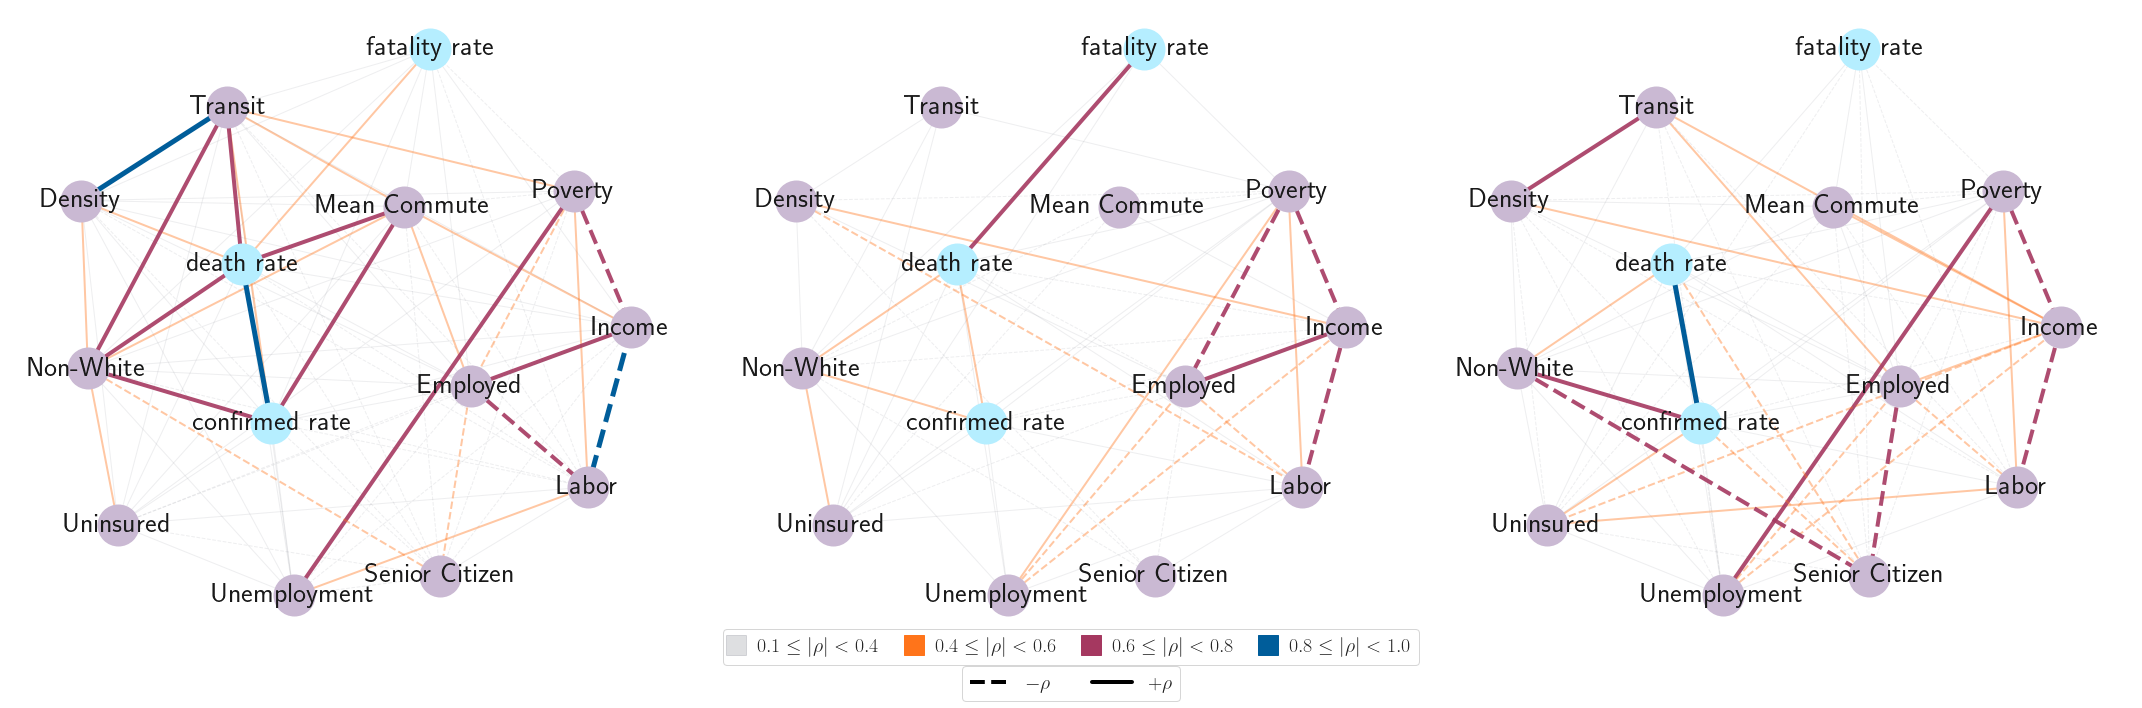

In [138]:
# make the graphs here
# setting
font = {'family': 'serif',
        'color':  '#34495E',
        'weight': 'heavy',
        'size': 25
        }
bbox_props = dict(boxstyle="round", fc="w", ec="none", alpha=0.9)

# initialize the graph
G = nx.Graph()
threshold = 0.4

plt.figure(figsize=(30,10))
name='../plots/networks.png'

plt.subplot(1,3,1)
plt.axis('off')
pos = []
pos = makeGraph(G, df=df_curated_plot_EC, threshold=threshold, pos=pos, seed=5, iterations=1100, kfactor=6.27)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1 - 0.15, x2 + 0.15, y1 - 0.25, y2 + 0.05))

plt.subplot(1,3,2)
plt.axis('off')
pos = makeGraph(G, df=df_curated_plot_SS, threshold=threshold, pos=pos, seed=5, iterations=1100, kfactor=6.27)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1 - 0.15, x2 + 0.15, y1 - 0.25, y2 + 0.05))

plt.subplot(1,3,3)
plt.axis('off')
pos = makeGraph(G, df=df_curated_plot_WC, threshold=threshold, pos=pos, seed=5, iterations=1100, kfactor=6.27)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1 - 0.15, x2 + 0.15, y1 - 0.25, y2 + 0.05))

makeEdgeLegend(plt, 0.0, 20)


plt.tight_layout()
plt.savefig(name, dpi=300)
plt.show(block=False)
plt.close('all')

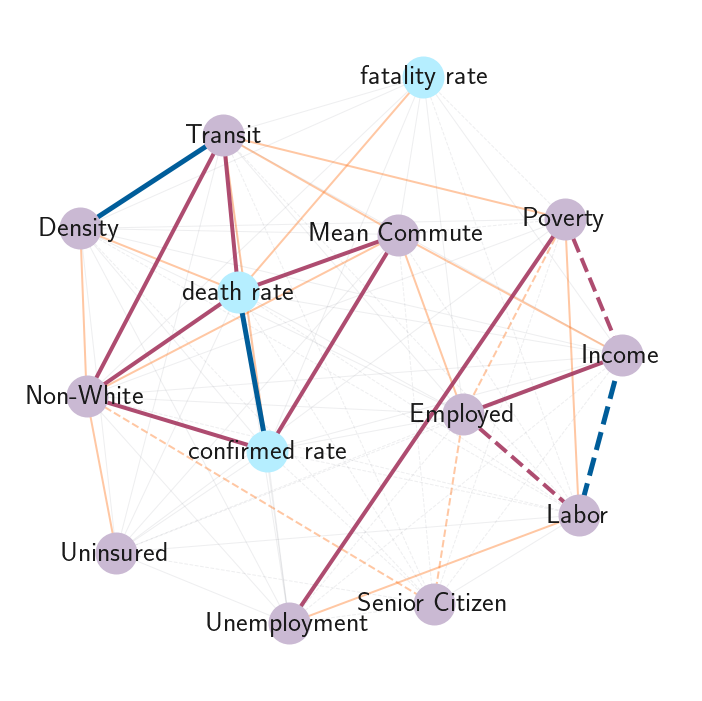

In [136]:
plt.figure(figsize=(10,10))
# plt.subplots_adjust(bottom=0.15, wspace=0.075, hspace=0.075)
name='../plots/networks-EC.png'

plt.axis('off')
pos = makeGraph(G, df=df_curated_plot_EC, threshold=threshold, pos=pos, seed=5, iterations=1100, kfactor=6.27)


x1,x2,y1,y2 = plt.axis()
plt.axis((x1 - 0.15, x2 + 0.15, y1 - 0.15, y2 + 0.15))
plt.tight_layout()
plt.savefig(name, dpi=300)
plt.show(block=False)
plt.close('all')

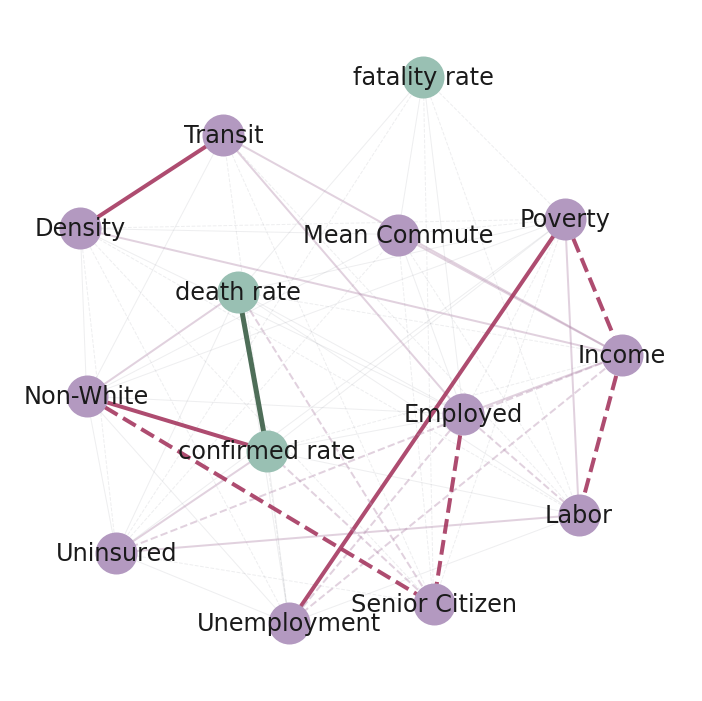

In [96]:
plt.figure(figsize=(10,10))
# plt.subplots_adjust(bottom=0.15, wspace=0.075, hspace=0.075)
name='../plots/networks-WC.png'

plt.axis('off')
pos = makeGraph(G, df=df_curated_plot_WC, threshold=threshold, pos=pos, seed=5, iterations=1100, kfactor=6.27)


x1,x2,y1,y2 = plt.axis()
plt.axis((x1 - 0.15, x2 + 0.15, y1 - 0.15, y2 + 0.15))
plt.tight_layout()
plt.savefig(name, dpi=300)
plt.show(block=False)
plt.close('all')